In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import random_split, DataLoader
import time
from tqdm import tqdm

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 dataset loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [4]:
train_size = int(0.85 * len(train_dataset))
validation_size = len(train_dataset) - train_size
train_subset, validation_subset = random_split(train_dataset, [train_size, validation_size])
print(f"Train size: {train_size}, Validation size: {validation_size} Test size: {len(test_dataset)}")

Train size: 42500, Validation size: 7500 Test size: 10000


In [5]:
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
# Define a CNN model with configurable activation functions for each layer
class CNNModel(nn.Module):
    def __init__(self, activations=None):
        super(CNNModel, self).__init__()

        if activations is None:
            activations = [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()]

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            activations[0],
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            activations[1],
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            activations[2],
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.activation_fc = activations[3]
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.activation_fc(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [7]:
# Training function with progress tracking
def train_val_model(model, num_epochs=20):
    train={
        'loss': [],
        'accuracy': [],
        'f1_score': [],
        'time': []
    }
    validation={
        'loss': [],
        'accuracy': [],
        'f1_score': [],
        'time': []
    }
    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()
        predictions_train = []
        labels_train = []
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)
        epoch_loss = 0
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix({'Loss': loss.item()})

            _, predicted = torch.max(outputs.data, 1)
            predictions_train.extend(predicted.cpu().numpy())
            labels_train.extend(labels.cpu().numpy())

        avg_loss = epoch_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Avg Loss: {avg_loss:.4f}, Time: {time.time() - start_time:.2f}s')
        
        train['loss'].append(avg_loss)
        train['accuracy'].append(accuracy_score(labels_train, predictions_train))
        train['f1_score'].append(f1_score(labels_train, predictions_train, average='weighted'))
        train['time'].append(time.time() - start_time)

        print("Train loss: {:.2f}, accuracy: {:.2f}, f1_score: {:.2f}".format(train['loss'][-1], train['accuracy'][-1], train['f1_score'][-1]))

        model.eval()
        epoch_loss = 0
        predictions_val = []
        labels_val = []
        start_time = time.time()
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                predictions_val.extend(predicted.cpu().numpy())
                labels_val.extend(labels.cpu().numpy())

        validation['loss'].append(epoch_loss / len(validation_loader))
        validation['accuracy'].append(accuracy_score(labels_val, predictions_val))
        validation['f1_score'].append(f1_score(labels_val, predictions_val, average='weighted'))
        validation['time'].append(time.time() - start_time)
        print("Validation loss: {:.2f}, accuracy: {:.2f}, f1_score: {:.2f}".format(validation['loss'][-1], validation['accuracy'][-1], validation['f1_score'][-1]))

    
    epochs = range(1, num_epochs + 1)
    fig, axs = plt.subplots(2, 2, figsize=(13, 8))

    axs[0, 0].plot(epochs, train['loss'], label='Train loss')
    axs[0, 0].plot(epochs, validation['loss'], label='Validation loss')
    axs[0, 0].set_title('Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    axs[0, 1].plot(epochs, train['accuracy'], label='Train accuracy')
    axs[0, 1].plot(epochs, validation['accuracy'], label='Validation accuracy')
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()

    axs[1, 0].plot(epochs, train['f1_score'], label='Train f1_score')
    axs[1, 0].plot(epochs, validation['f1_score'], label='Validation f1_score')
    axs[1, 0].set_title('F1 Score')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('F1 Score')
    axs[1, 0].legend()

    axs[1, 1].plot(epochs, train['time'], label='Train time')
    axs[1, 1].plot(epochs, validation['time'], label='Validation time')
    axs[1, 1].set_title('Time')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Time')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


In [8]:
# Evaluation function with detailed output
def evaluate_model(model, test_loader):
    model.eval()
    temp_loss = 0
    predictions = []
    labels_test = []
    start_time = time.time()

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            temp_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            labels_test.extend(labels.cpu().numpy())

    print(f"Loss: {temp_loss / len(test_loader):.2f}, Time: {time.time() - start_time:.2f}s, Accuracy: {accuracy_score(labels_test, predictions):.2f}, F1 Score: {f1_score(labels_test, predictions, average='weighted'):.2f}")


In [9]:
combinations_of_activations = {}
combinations_of_activations['ReLU'] = [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()]
combinations_of_activations['Sigmoid'] = [nn.Sigmoid(), nn.Sigmoid(), nn.Sigmoid(), nn.Sigmoid()]
combinations_of_activations['Tanh'] = [nn.Tanh(), nn.Tanh(), nn.Tanh(), nn.Tanh()]
combinations_of_activations['LeakyReLU(0.01)'] = [nn.LeakyReLU(0.01), nn.LeakyReLU(0.01), nn.LeakyReLU(0.01), nn.LeakyReLU(0.01)]
combinations_of_activations['LeakyReLU(0.1)'] = [nn.LeakyReLU(0.1), nn.LeakyReLU(0.1), nn.LeakyReLU(0.1), nn.LeakyReLU(0.1)]
combinations_of_activations['LeakyReLU(0.2)'] = [nn.LeakyReLU(0.2), nn.LeakyReLU(0.2), nn.LeakyReLU(0.2), nn.LeakyReLU(0.2)]
combinations_of_activations['Swish'] = [nn.SiLU(), nn.SiLU(), nn.SiLU(), nn.SiLU()]
combinations_of_activations['GELU'] = [nn.GELU(), nn.GELU(), nn.GELU(), nn.GELU()]
combinations_of_activations['Mish'] = [nn.Mish(), nn.Mish(), nn.Mish(), nn.Mish()]
combinations_of_activations['SELU'] = [nn.SELU(), nn.SELU(), nn.SELU(), nn.SELU()]

Training model with activationReLU


Epoch [1/20], Avg Loss: 1.4386, Time: 13.92s
Train loss: 1.44, accuracy: 0.48, f1_score: 0.47
Validation loss: 1.16, accuracy: 0.58, f1_score: 0.58


Epoch [2/20], Avg Loss: 1.0933, Time: 12.79s
Train loss: 1.09, accuracy: 0.61, f1_score: 0.61
Validation loss: 1.07, accuracy: 0.62, f1_score: 0.62


Epoch [3/20], Avg Loss: 0.9460, Time: 12.78s
Train loss: 0.95, accuracy: 0.67, f1_score: 0.66
Validation loss: 0.82, accuracy: 0.71, f1_score: 0.71


Epoch [4/20], Avg Loss: 0.8522, Time: 12.78s
Train loss: 0.85, accuracy: 0.70, f1_score: 0.70
Validation loss: 0.87, accuracy: 0.70, f1_score: 0.69


Epoch [5/20], Avg Loss: 0.7784, Time: 12.87s
Train loss: 0.78, accuracy: 0.73, f1_score: 0.73
Validation loss: 0.73, accuracy: 0.74, f1_score: 0.74


Epoch [6/20], Avg Loss: 0.7185, Time: 12.86s
Train loss: 0.72, accuracy: 0.75, f1_score: 0.75
Validation loss: 0.77, accuracy: 0.74, f1_score: 0.74


Epoch [7/20], Avg Loss: 0.6596, Time: 12.78s
Train loss: 0.66, accuracy: 0.77, f1_score: 0.77
Validation loss: 0.65, accuracy: 0.77, f1_score: 0.77


Epoch [8/20], Avg Loss: 0.6067, Time: 12.73s
Train loss: 0.61, accuracy: 0.79, f1_score: 0.79
Validation loss: 0.65, accuracy: 0.77, f1_score: 0.77


Epoch [9/20], Avg Loss: 0.5638, Time: 12.77s
Train loss: 0.56, accuracy: 0.80, f1_score: 0.80
Validation loss: 0.68, accuracy: 0.77, f1_score: 0.77


Epoch [10/20], Avg Loss: 0.5183, Time: 12.77s
Train loss: 0.52, accuracy: 0.82, f1_score: 0.82
Validation loss: 0.66, accuracy: 0.78, f1_score: 0.78


Epoch [11/20], Avg Loss: 0.4793, Time: 12.84s
Train loss: 0.48, accuracy: 0.83, f1_score: 0.83
Validation loss: 0.64, accuracy: 0.79, f1_score: 0.79


Epoch [12/20], Avg Loss: 0.4538, Time: 12.81s
Train loss: 0.45, accuracy: 0.84, f1_score: 0.84
Validation loss: 0.64, accuracy: 0.79, f1_score: 0.79


Epoch [13/20], Avg Loss: 0.4107, Time: 12.72s
Train loss: 0.41, accuracy: 0.85, f1_score: 0.85
Validation loss: 0.72, accuracy: 0.77, f1_score: 0.77


Epoch [14/20], Avg Loss: 0.3797, Time: 12.94s
Train loss: 0.38, accuracy: 0.87, f1_score: 0.87
Validation loss: 0.73, accuracy: 0.78, f1_score: 0.78


Epoch [15/20], Avg Loss: 0.3592, Time: 12.78s
Train loss: 0.36, accuracy: 0.87, f1_score: 0.87
Validation loss: 0.68, accuracy: 0.79, f1_score: 0.79


Epoch [16/20], Avg Loss: 0.3305, Time: 13.01s
Train loss: 0.33, accuracy: 0.88, f1_score: 0.88
Validation loss: 0.71, accuracy: 0.78, f1_score: 0.78


Epoch [17/20], Avg Loss: 0.3104, Time: 12.80s
Train loss: 0.31, accuracy: 0.89, f1_score: 0.89
Validation loss: 0.77, accuracy: 0.78, f1_score: 0.78


Epoch [18/20], Avg Loss: 0.2932, Time: 12.80s
Train loss: 0.29, accuracy: 0.89, f1_score: 0.89
Validation loss: 0.78, accuracy: 0.78, f1_score: 0.78


Epoch [19/20], Avg Loss: 0.2699, Time: 12.78s
Train loss: 0.27, accuracy: 0.90, f1_score: 0.90
Validation loss: 0.76, accuracy: 0.79, f1_score: 0.79


Epoch [20/20], Avg Loss: 0.2516, Time: 12.81s
Train loss: 0.25, accuracy: 0.91, f1_score: 0.91
Validation loss: 0.77, accuracy: 0.79, f1_score: 0.79


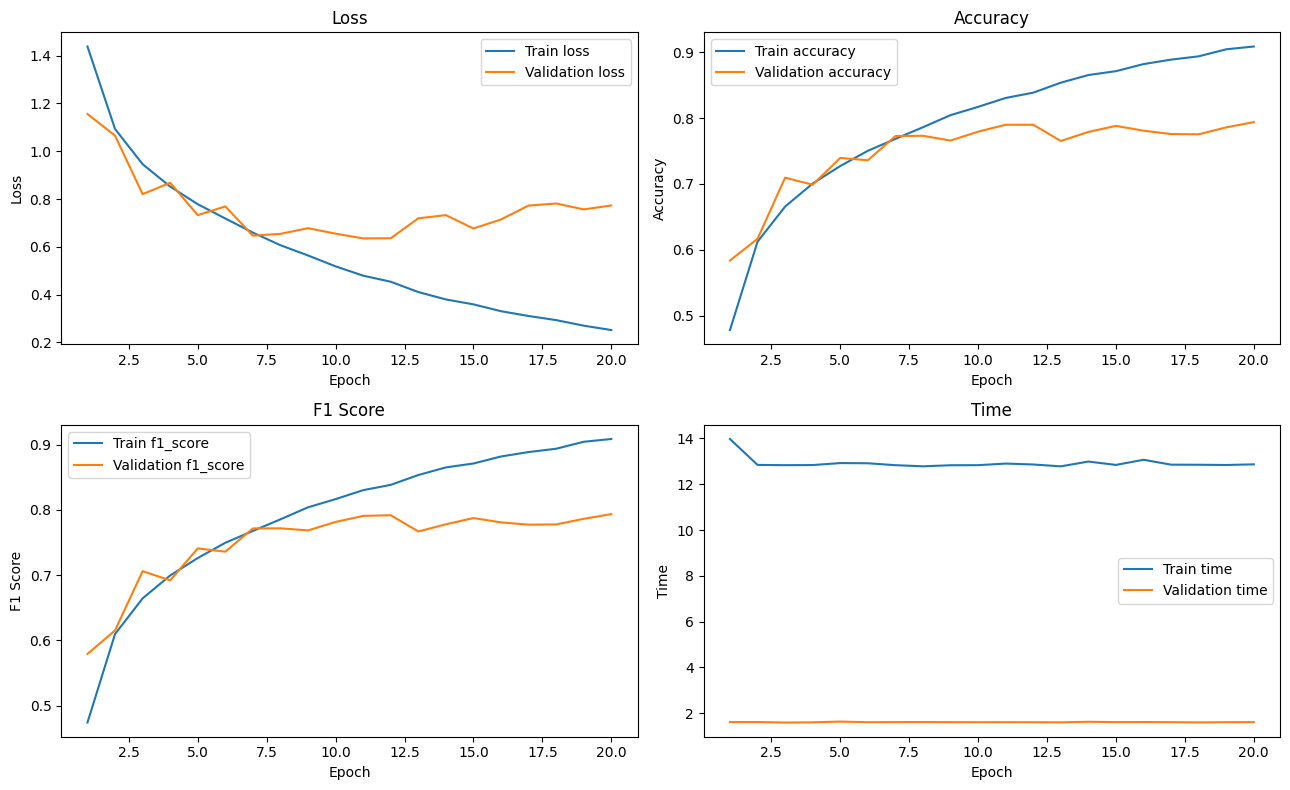

Loss: 0.83, Time: 2.20s, Accuracy: 0.79, F1 Score: 0.79
Training model with activationSigmoid


Epoch [1/20], Avg Loss: 1.7696, Time: 12.80s
Train loss: 1.77, accuracy: 0.33, f1_score: 0.32
Validation loss: 1.84, accuracy: 0.35, f1_score: 0.33


Epoch [2/20], Avg Loss: 1.4630, Time: 12.78s
Train loss: 1.46, accuracy: 0.46, f1_score: 0.45
Validation loss: 1.57, accuracy: 0.43, f1_score: 0.41


Epoch [3/20], Avg Loss: 1.3317, Time: 12.63s
Train loss: 1.33, accuracy: 0.51, f1_score: 0.51
Validation loss: 1.33, accuracy: 0.52, f1_score: 0.51


Epoch [4/20], Avg Loss: 1.2374, Time: 12.68s
Train loss: 1.24, accuracy: 0.55, f1_score: 0.54
Validation loss: 2.14, accuracy: 0.32, f1_score: 0.32


Epoch [5/20], Avg Loss: 1.1624, Time: 12.70s
Train loss: 1.16, accuracy: 0.58, f1_score: 0.58
Validation loss: 2.15, accuracy: 0.37, f1_score: 0.32


Epoch [6/20], Avg Loss: 1.1065, Time: 13.01s
Train loss: 1.11, accuracy: 0.60, f1_score: 0.60
Validation loss: 1.27, accuracy: 0.53, f1_score: 0.51


Epoch [7/20], Avg Loss: 1.0686, Time: 13.07s
Train loss: 1.07, accuracy: 0.62, f1_score: 0.61
Validation loss: 1.25, accuracy: 0.56, f1_score: 0.57


Epoch [8/20], Avg Loss: 1.0139, Time: 12.91s
Train loss: 1.01, accuracy: 0.64, f1_score: 0.63
Validation loss: 1.02, accuracy: 0.63, f1_score: 0.62


Epoch [9/20], Avg Loss: 0.9869, Time: 12.79s
Train loss: 0.99, accuracy: 0.65, f1_score: 0.65
Validation loss: 1.67, accuracy: 0.50, f1_score: 0.46


Epoch [10/20], Avg Loss: 0.9416, Time: 12.76s
Train loss: 0.94, accuracy: 0.67, f1_score: 0.66
Validation loss: 1.50, accuracy: 0.50, f1_score: 0.47


Epoch [11/20], Avg Loss: 0.9141, Time: 12.72s
Train loss: 0.91, accuracy: 0.67, f1_score: 0.67
Validation loss: 0.99, accuracy: 0.65, f1_score: 0.63


Epoch [12/20], Avg Loss: 0.8888, Time: 12.76s
Train loss: 0.89, accuracy: 0.68, f1_score: 0.68
Validation loss: 0.92, accuracy: 0.67, f1_score: 0.66


Epoch [13/20], Avg Loss: 0.8666, Time: 12.71s
Train loss: 0.87, accuracy: 0.69, f1_score: 0.69
Validation loss: 1.22, accuracy: 0.57, f1_score: 0.59


Epoch [14/20], Avg Loss: 0.8452, Time: 12.74s
Train loss: 0.85, accuracy: 0.70, f1_score: 0.70
Validation loss: 1.04, accuracy: 0.63, f1_score: 0.63


Epoch [15/20], Avg Loss: 0.8229, Time: 12.80s
Train loss: 0.82, accuracy: 0.71, f1_score: 0.71
Validation loss: 1.04, accuracy: 0.65, f1_score: 0.64


Epoch [16/20], Avg Loss: 0.8083, Time: 12.82s
Train loss: 0.81, accuracy: 0.71, f1_score: 0.71
Validation loss: 1.23, accuracy: 0.60, f1_score: 0.58


Epoch [17/20], Avg Loss: 0.7756, Time: 12.76s
Train loss: 0.78, accuracy: 0.73, f1_score: 0.73
Validation loss: 0.90, accuracy: 0.68, f1_score: 0.68


Epoch [18/20], Avg Loss: 0.7606, Time: 12.74s
Train loss: 0.76, accuracy: 0.73, f1_score: 0.73
Validation loss: 1.04, accuracy: 0.64, f1_score: 0.63


Epoch [19/20], Avg Loss: 0.7511, Time: 12.76s
Train loss: 0.75, accuracy: 0.74, f1_score: 0.74
Validation loss: 0.96, accuracy: 0.67, f1_score: 0.67


Epoch [20/20], Avg Loss: 0.7289, Time: 12.73s
Train loss: 0.73, accuracy: 0.74, f1_score: 0.74
Validation loss: 1.49, accuracy: 0.56, f1_score: 0.52


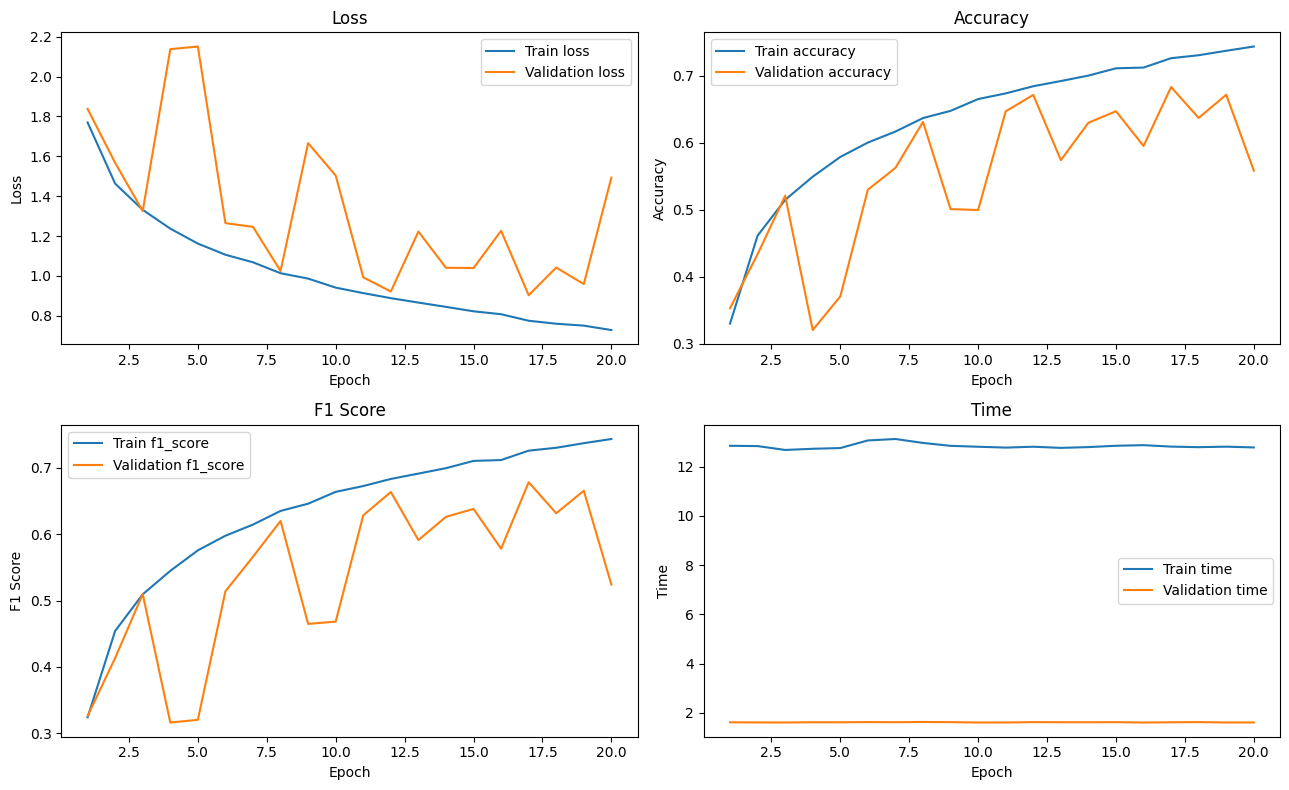

Loss: 1.49, Time: 2.18s, Accuracy: 0.56, F1 Score: 0.52
Training model with activationTanh


Epoch [1/20], Avg Loss: 1.4469, Time: 12.77s
Train loss: 1.45, accuracy: 0.48, f1_score: 0.47
Validation loss: 1.20, accuracy: 0.57, f1_score: 0.56


Epoch [2/20], Avg Loss: 1.1406, Time: 12.74s
Train loss: 1.14, accuracy: 0.59, f1_score: 0.59
Validation loss: 1.06, accuracy: 0.62, f1_score: 0.62


Epoch [3/20], Avg Loss: 0.9953, Time: 12.75s
Train loss: 1.00, accuracy: 0.65, f1_score: 0.65
Validation loss: 0.93, accuracy: 0.67, f1_score: 0.67


Epoch [4/20], Avg Loss: 0.9083, Time: 12.73s
Train loss: 0.91, accuracy: 0.68, f1_score: 0.68
Validation loss: 0.95, accuracy: 0.67, f1_score: 0.66


Epoch [5/20], Avg Loss: 0.8337, Time: 12.73s
Train loss: 0.83, accuracy: 0.71, f1_score: 0.70
Validation loss: 0.90, accuracy: 0.69, f1_score: 0.69


Epoch [6/20], Avg Loss: 0.7766, Time: 12.75s
Train loss: 0.78, accuracy: 0.73, f1_score: 0.72
Validation loss: 0.88, accuracy: 0.70, f1_score: 0.69


Epoch [7/20], Avg Loss: 0.7144, Time: 12.72s
Train loss: 0.71, accuracy: 0.75, f1_score: 0.75
Validation loss: 0.79, accuracy: 0.73, f1_score: 0.73


Epoch [8/20], Avg Loss: 0.6750, Time: 12.80s
Train loss: 0.67, accuracy: 0.76, f1_score: 0.76
Validation loss: 0.81, accuracy: 0.73, f1_score: 0.73


Epoch [9/20], Avg Loss: 0.6287, Time: 13.00s
Train loss: 0.63, accuracy: 0.78, f1_score: 0.78
Validation loss: 0.78, accuracy: 0.73, f1_score: 0.73


Epoch [10/20], Avg Loss: 0.5829, Time: 12.76s
Train loss: 0.58, accuracy: 0.80, f1_score: 0.80
Validation loss: 0.79, accuracy: 0.73, f1_score: 0.73


Epoch [11/20], Avg Loss: 0.5509, Time: 12.69s
Train loss: 0.55, accuracy: 0.80, f1_score: 0.80
Validation loss: 0.79, accuracy: 0.74, f1_score: 0.74


Epoch [12/20], Avg Loss: 0.5104, Time: 12.94s
Train loss: 0.51, accuracy: 0.82, f1_score: 0.82
Validation loss: 0.84, accuracy: 0.73, f1_score: 0.73


Epoch [13/20], Avg Loss: 0.4685, Time: 12.73s
Train loss: 0.47, accuracy: 0.83, f1_score: 0.83
Validation loss: 0.82, accuracy: 0.74, f1_score: 0.74


Epoch [14/20], Avg Loss: 0.4417, Time: 12.71s
Train loss: 0.44, accuracy: 0.84, f1_score: 0.84
Validation loss: 0.85, accuracy: 0.73, f1_score: 0.73


Epoch [15/20], Avg Loss: 0.4018, Time: 12.77s
Train loss: 0.40, accuracy: 0.86, f1_score: 0.86
Validation loss: 0.87, accuracy: 0.74, f1_score: 0.74


Epoch [16/20], Avg Loss: 0.3837, Time: 12.78s
Train loss: 0.38, accuracy: 0.87, f1_score: 0.87
Validation loss: 0.88, accuracy: 0.74, f1_score: 0.73


Epoch [17/20], Avg Loss: 0.3569, Time: 12.74s
Train loss: 0.36, accuracy: 0.87, f1_score: 0.87
Validation loss: 0.89, accuracy: 0.73, f1_score: 0.73


Epoch [18/20], Avg Loss: 0.3304, Time: 12.77s
Train loss: 0.33, accuracy: 0.88, f1_score: 0.88
Validation loss: 0.94, accuracy: 0.74, f1_score: 0.74


Epoch [19/20], Avg Loss: 0.2974, Time: 12.77s
Train loss: 0.30, accuracy: 0.89, f1_score: 0.89
Validation loss: 0.95, accuracy: 0.73, f1_score: 0.73


Epoch [20/20], Avg Loss: 0.2852, Time: 12.72s
Train loss: 0.29, accuracy: 0.90, f1_score: 0.90
Validation loss: 1.03, accuracy: 0.73, f1_score: 0.73


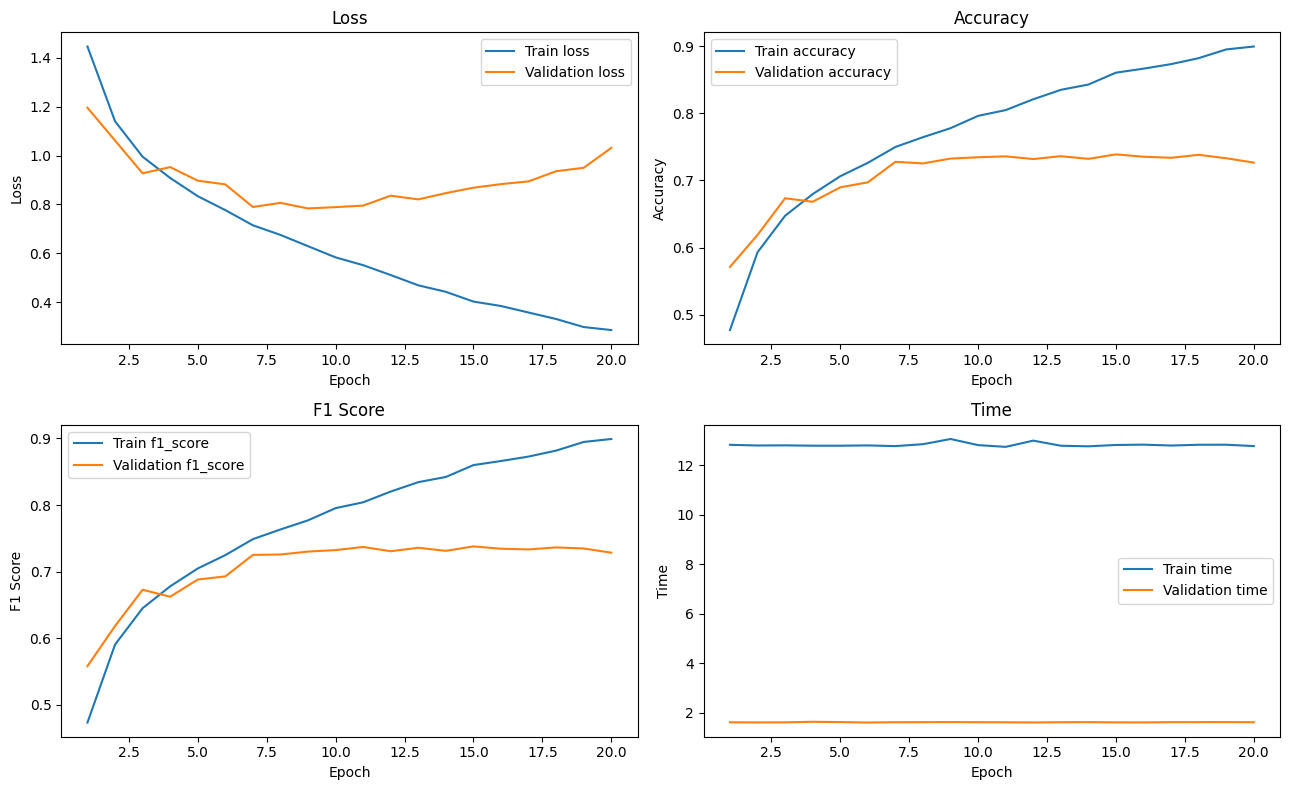

Loss: 1.01, Time: 2.18s, Accuracy: 0.73, F1 Score: 0.73
Training model with activationLeakyReLU(0.01)


Epoch [1/20], Avg Loss: 1.4156, Time: 12.77s
Train loss: 1.42, accuracy: 0.48, f1_score: 0.48
Validation loss: 1.16, accuracy: 0.59, f1_score: 0.58


Epoch [2/20], Avg Loss: 1.0686, Time: 12.70s
Train loss: 1.07, accuracy: 0.62, f1_score: 0.62
Validation loss: 0.91, accuracy: 0.67, f1_score: 0.66


Epoch [3/20], Avg Loss: 0.9277, Time: 12.78s
Train loss: 0.93, accuracy: 0.67, f1_score: 0.67
Validation loss: 0.84, accuracy: 0.71, f1_score: 0.70


Epoch [4/20], Avg Loss: 0.8343, Time: 12.83s
Train loss: 0.83, accuracy: 0.71, f1_score: 0.71
Validation loss: 0.77, accuracy: 0.73, f1_score: 0.73


Epoch [5/20], Avg Loss: 0.7576, Time: 12.83s
Train loss: 0.76, accuracy: 0.73, f1_score: 0.73
Validation loss: 0.82, accuracy: 0.72, f1_score: 0.72


Epoch [6/20], Avg Loss: 0.6917, Time: 12.79s
Train loss: 0.69, accuracy: 0.76, f1_score: 0.76
Validation loss: 0.77, accuracy: 0.73, f1_score: 0.72


Epoch [7/20], Avg Loss: 0.6305, Time: 12.85s
Train loss: 0.63, accuracy: 0.78, f1_score: 0.78
Validation loss: 0.68, accuracy: 0.77, f1_score: 0.77


Epoch [8/20], Avg Loss: 0.5705, Time: 12.86s
Train loss: 0.57, accuracy: 0.80, f1_score: 0.80
Validation loss: 0.70, accuracy: 0.76, f1_score: 0.76


Epoch [9/20], Avg Loss: 0.5269, Time: 12.74s
Train loss: 0.53, accuracy: 0.81, f1_score: 0.81
Validation loss: 0.69, accuracy: 0.77, f1_score: 0.77


Epoch [10/20], Avg Loss: 0.4705, Time: 12.71s
Train loss: 0.47, accuracy: 0.83, f1_score: 0.83
Validation loss: 0.69, accuracy: 0.77, f1_score: 0.77


Epoch [11/20], Avg Loss: 0.4355, Time: 12.91s
Train loss: 0.44, accuracy: 0.84, f1_score: 0.84
Validation loss: 0.65, accuracy: 0.78, f1_score: 0.78


Epoch [12/20], Avg Loss: 0.3973, Time: 12.61s
Train loss: 0.40, accuracy: 0.86, f1_score: 0.86
Validation loss: 0.67, accuracy: 0.79, f1_score: 0.79


Epoch [13/20], Avg Loss: 0.3756, Time: 12.91s
Train loss: 0.38, accuracy: 0.87, f1_score: 0.87
Validation loss: 0.68, accuracy: 0.79, f1_score: 0.79


Epoch [14/20], Avg Loss: 0.3229, Time: 12.84s
Train loss: 0.32, accuracy: 0.89, f1_score: 0.89
Validation loss: 0.72, accuracy: 0.78, f1_score: 0.78


Epoch [15/20], Avg Loss: 0.3015, Time: 12.61s
Train loss: 0.30, accuracy: 0.89, f1_score: 0.89
Validation loss: 0.69, accuracy: 0.79, f1_score: 0.79


Epoch [16/20], Avg Loss: 0.2726, Time: 12.87s
Train loss: 0.27, accuracy: 0.90, f1_score: 0.90
Validation loss: 0.70, accuracy: 0.79, f1_score: 0.79


Epoch [17/20], Avg Loss: 0.2407, Time: 12.89s
Train loss: 0.24, accuracy: 0.91, f1_score: 0.91
Validation loss: 0.74, accuracy: 0.80, f1_score: 0.80


Epoch [18/20], Avg Loss: 0.2169, Time: 12.72s
Train loss: 0.22, accuracy: 0.92, f1_score: 0.92
Validation loss: 0.77, accuracy: 0.79, f1_score: 0.79


Epoch [19/20], Avg Loss: 0.2089, Time: 12.69s
Train loss: 0.21, accuracy: 0.93, f1_score: 0.93
Validation loss: 0.90, accuracy: 0.77, f1_score: 0.77


Epoch [20/20], Avg Loss: 0.1783, Time: 12.62s
Train loss: 0.18, accuracy: 0.94, f1_score: 0.94
Validation loss: 0.83, accuracy: 0.79, f1_score: 0.79


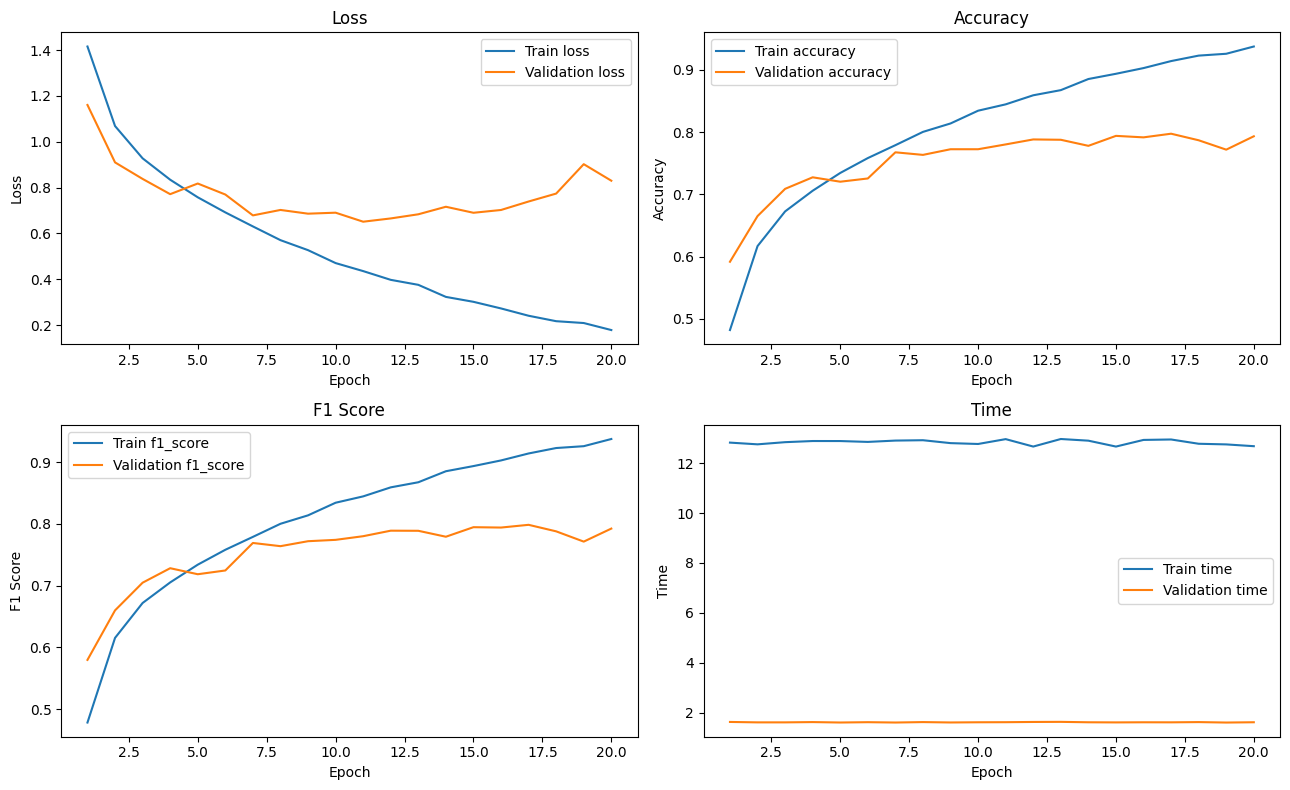

Loss: 0.84, Time: 2.17s, Accuracy: 0.79, F1 Score: 0.79
Training model with activationLeakyReLU(0.1)


Epoch [1/20], Avg Loss: 1.3477, Time: 12.86s
Train loss: 1.35, accuracy: 0.52, f1_score: 0.51
Validation loss: 1.14, accuracy: 0.59, f1_score: 0.58


Epoch [2/20], Avg Loss: 0.9611, Time: 12.83s
Train loss: 0.96, accuracy: 0.66, f1_score: 0.66
Validation loss: 0.89, accuracy: 0.69, f1_score: 0.69


Epoch [3/20], Avg Loss: 0.8259, Time: 12.84s
Train loss: 0.83, accuracy: 0.71, f1_score: 0.71
Validation loss: 0.77, accuracy: 0.72, f1_score: 0.72


Epoch [4/20], Avg Loss: 0.7182, Time: 12.98s
Train loss: 0.72, accuracy: 0.75, f1_score: 0.75
Validation loss: 0.79, accuracy: 0.73, f1_score: 0.73


Epoch [5/20], Avg Loss: 0.6383, Time: 12.65s
Train loss: 0.64, accuracy: 0.78, f1_score: 0.78
Validation loss: 0.70, accuracy: 0.76, f1_score: 0.76


Epoch [6/20], Avg Loss: 0.5636, Time: 14.23s
Train loss: 0.56, accuracy: 0.80, f1_score: 0.80
Validation loss: 0.68, accuracy: 0.77, f1_score: 0.76


Epoch [7/20], Avg Loss: 0.5029, Time: 13.41s
Train loss: 0.50, accuracy: 0.82, f1_score: 0.82
Validation loss: 0.68, accuracy: 0.77, f1_score: 0.77


Epoch [8/20], Avg Loss: 0.4482, Time: 12.72s
Train loss: 0.45, accuracy: 0.84, f1_score: 0.84
Validation loss: 0.65, accuracy: 0.78, f1_score: 0.78


Epoch [9/20], Avg Loss: 0.3906, Time: 12.83s
Train loss: 0.39, accuracy: 0.86, f1_score: 0.86
Validation loss: 0.67, accuracy: 0.78, f1_score: 0.78


Epoch [10/20], Avg Loss: 0.3502, Time: 12.96s
Train loss: 0.35, accuracy: 0.88, f1_score: 0.88
Validation loss: 0.68, accuracy: 0.78, f1_score: 0.78


Epoch [11/20], Avg Loss: 0.3049, Time: 12.72s
Train loss: 0.30, accuracy: 0.89, f1_score: 0.89
Validation loss: 0.75, accuracy: 0.78, f1_score: 0.79


Epoch [12/20], Avg Loss: 0.2643, Time: 12.94s
Train loss: 0.26, accuracy: 0.90, f1_score: 0.90
Validation loss: 0.70, accuracy: 0.79, f1_score: 0.79


Epoch [13/20], Avg Loss: 0.2381, Time: 13.07s
Train loss: 0.24, accuracy: 0.91, f1_score: 0.91
Validation loss: 0.73, accuracy: 0.79, f1_score: 0.79


Epoch [14/20], Avg Loss: 0.2170, Time: 12.79s
Train loss: 0.22, accuracy: 0.92, f1_score: 0.92
Validation loss: 0.79, accuracy: 0.79, f1_score: 0.79


Epoch [15/20], Avg Loss: 0.1942, Time: 12.90s
Train loss: 0.19, accuracy: 0.93, f1_score: 0.93
Validation loss: 0.82, accuracy: 0.79, f1_score: 0.79


Epoch [16/20], Avg Loss: 0.1764, Time: 12.79s
Train loss: 0.18, accuracy: 0.94, f1_score: 0.94
Validation loss: 0.85, accuracy: 0.78, f1_score: 0.78


Epoch [17/20], Avg Loss: 0.1591, Time: 12.72s
Train loss: 0.16, accuracy: 0.94, f1_score: 0.94
Validation loss: 0.85, accuracy: 0.79, f1_score: 0.79


Epoch [18/20], Avg Loss: 0.1439, Time: 13.04s
Train loss: 0.14, accuracy: 0.95, f1_score: 0.95
Validation loss: 0.92, accuracy: 0.78, f1_score: 0.79


Epoch [19/20], Avg Loss: 0.1301, Time: 12.79s
Train loss: 0.13, accuracy: 0.95, f1_score: 0.95
Validation loss: 1.03, accuracy: 0.77, f1_score: 0.77


Epoch [20/20], Avg Loss: 0.1471, Time: 12.88s
Train loss: 0.15, accuracy: 0.95, f1_score: 0.95
Validation loss: 1.04, accuracy: 0.78, f1_score: 0.78


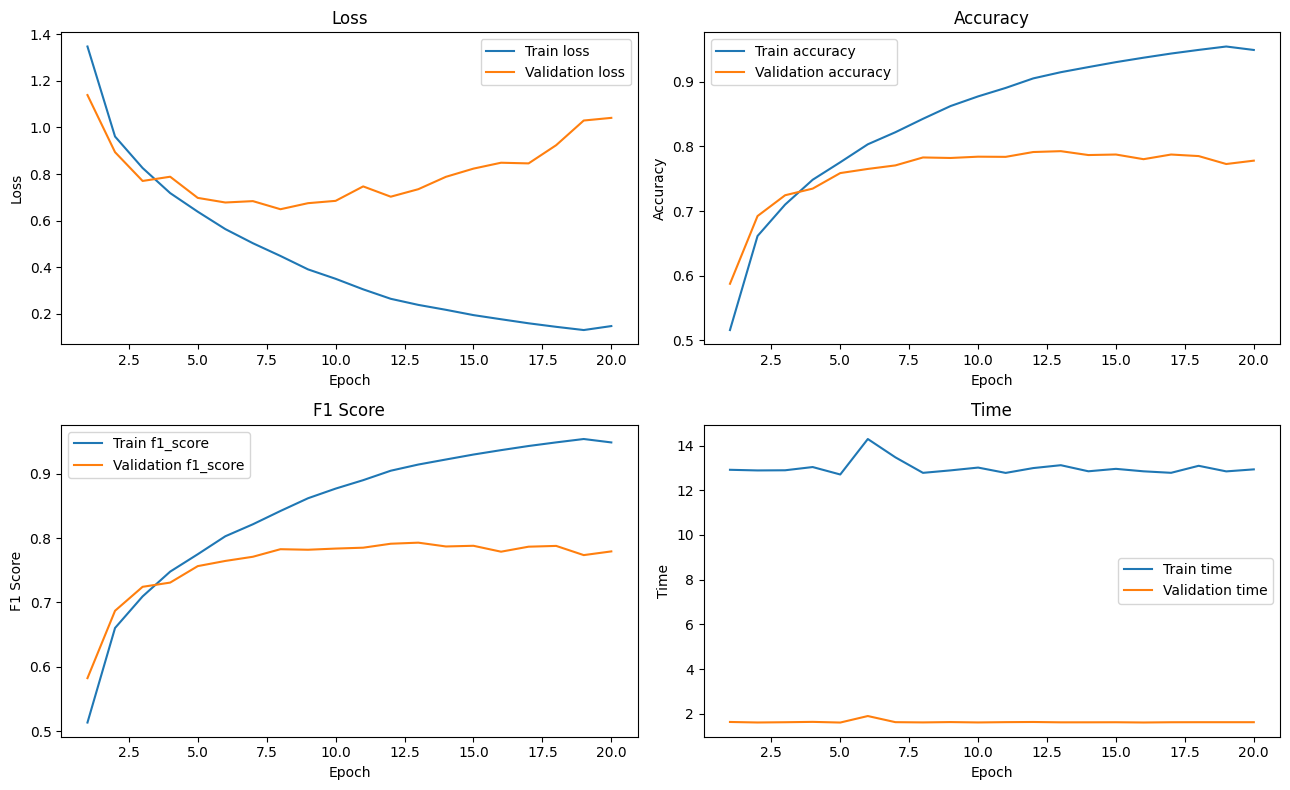

Loss: 0.99, Time: 2.18s, Accuracy: 0.78, F1 Score: 0.78
Training model with activationLeakyReLU(0.2)


Epoch [1/20], Avg Loss: 1.3304, Time: 12.75s
Train loss: 1.33, accuracy: 0.52, f1_score: 0.52
Validation loss: 1.08, accuracy: 0.62, f1_score: 0.62


Epoch [2/20], Avg Loss: 0.9482, Time: 12.79s
Train loss: 0.95, accuracy: 0.66, f1_score: 0.66
Validation loss: 0.88, accuracy: 0.69, f1_score: 0.69


Epoch [3/20], Avg Loss: 0.8118, Time: 12.80s
Train loss: 0.81, accuracy: 0.72, f1_score: 0.72
Validation loss: 0.84, accuracy: 0.71, f1_score: 0.71


Epoch [4/20], Avg Loss: 0.7190, Time: 12.80s
Train loss: 0.72, accuracy: 0.75, f1_score: 0.75
Validation loss: 0.70, accuracy: 0.76, f1_score: 0.75


Epoch [5/20], Avg Loss: 0.6371, Time: 12.81s
Train loss: 0.64, accuracy: 0.78, f1_score: 0.78
Validation loss: 0.68, accuracy: 0.76, f1_score: 0.76


Epoch [6/20], Avg Loss: 0.5646, Time: 12.75s
Train loss: 0.56, accuracy: 0.80, f1_score: 0.80
Validation loss: 0.66, accuracy: 0.77, f1_score: 0.77


Epoch [7/20], Avg Loss: 0.5007, Time: 12.77s
Train loss: 0.50, accuracy: 0.82, f1_score: 0.82
Validation loss: 0.66, accuracy: 0.78, f1_score: 0.77


Epoch [8/20], Avg Loss: 0.4438, Time: 12.73s
Train loss: 0.44, accuracy: 0.84, f1_score: 0.84
Validation loss: 0.65, accuracy: 0.78, f1_score: 0.78


Epoch [9/20], Avg Loss: 0.3951, Time: 12.83s
Train loss: 0.40, accuracy: 0.86, f1_score: 0.86
Validation loss: 0.77, accuracy: 0.75, f1_score: 0.75


Epoch [10/20], Avg Loss: 0.3486, Time: 12.70s
Train loss: 0.35, accuracy: 0.88, f1_score: 0.88
Validation loss: 0.75, accuracy: 0.77, f1_score: 0.78


Epoch [11/20], Avg Loss: 0.2981, Time: 13.00s
Train loss: 0.30, accuracy: 0.90, f1_score: 0.90
Validation loss: 0.71, accuracy: 0.79, f1_score: 0.78


Epoch [12/20], Avg Loss: 0.2729, Time: 12.82s
Train loss: 0.27, accuracy: 0.90, f1_score: 0.90
Validation loss: 0.75, accuracy: 0.78, f1_score: 0.78


Epoch [13/20], Avg Loss: 0.2366, Time: 12.95s
Train loss: 0.24, accuracy: 0.92, f1_score: 0.92
Validation loss: 0.78, accuracy: 0.78, f1_score: 0.78


Epoch [14/20], Avg Loss: 0.2147, Time: 13.21s
Train loss: 0.21, accuracy: 0.92, f1_score: 0.92
Validation loss: 0.87, accuracy: 0.77, f1_score: 0.77


Epoch [15/20], Avg Loss: 0.1985, Time: 12.80s
Train loss: 0.20, accuracy: 0.93, f1_score: 0.93
Validation loss: 0.84, accuracy: 0.78, f1_score: 0.79


Epoch [16/20], Avg Loss: 0.1791, Time: 12.93s
Train loss: 0.18, accuracy: 0.94, f1_score: 0.94
Validation loss: 0.91, accuracy: 0.77, f1_score: 0.77


Epoch [17/20], Avg Loss: 0.1702, Time: 12.77s
Train loss: 0.17, accuracy: 0.94, f1_score: 0.94
Validation loss: 0.94, accuracy: 0.78, f1_score: 0.78


Epoch [18/20], Avg Loss: 0.1532, Time: 12.80s
Train loss: 0.15, accuracy: 0.94, f1_score: 0.94
Validation loss: 0.93, accuracy: 0.78, f1_score: 0.78


Epoch [19/20], Avg Loss: 0.1332, Time: 12.76s
Train loss: 0.13, accuracy: 0.95, f1_score: 0.95
Validation loss: 1.08, accuracy: 0.77, f1_score: 0.77


Epoch [20/20], Avg Loss: 0.1390, Time: 12.71s
Train loss: 0.14, accuracy: 0.95, f1_score: 0.95
Validation loss: 1.04, accuracy: 0.77, f1_score: 0.77


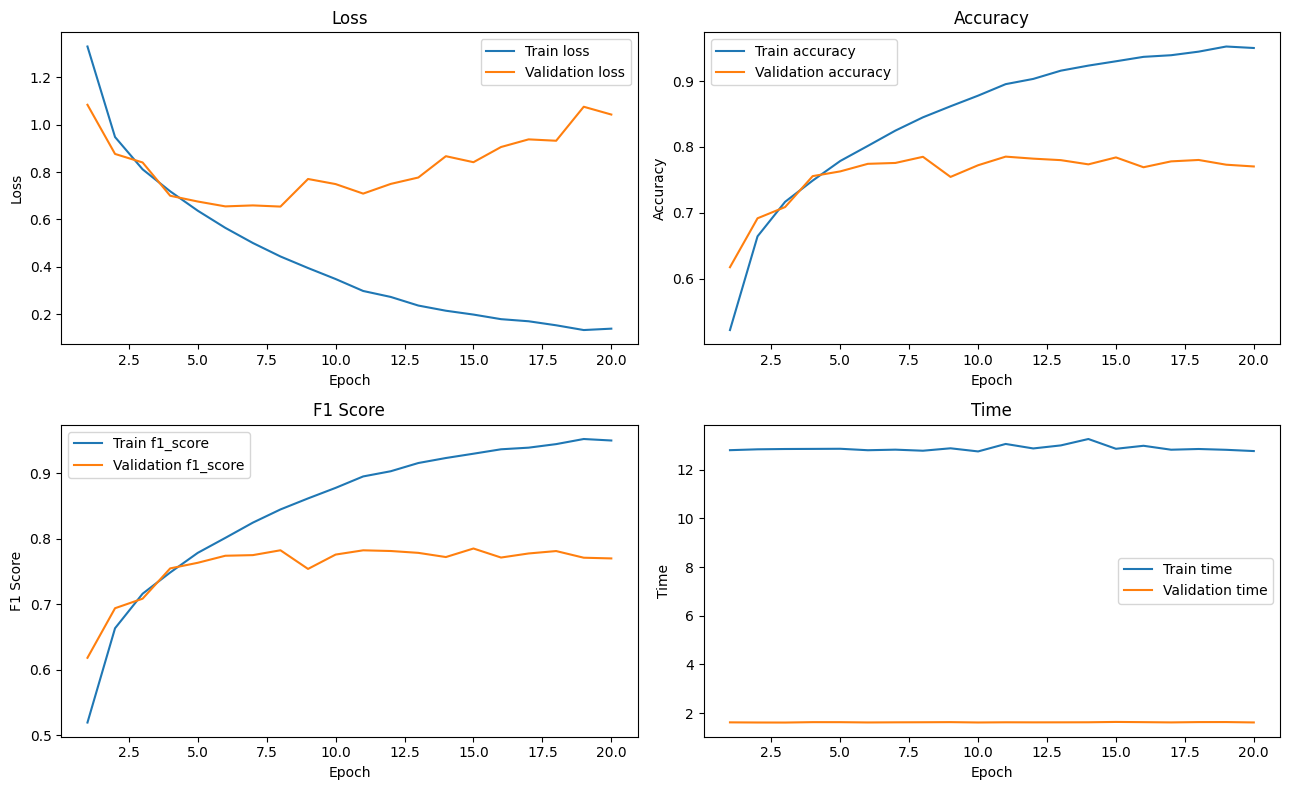

Loss: 1.06, Time: 2.18s, Accuracy: 0.77, F1 Score: 0.77
Training model with activationSwish


Epoch [1/20], Avg Loss: 1.3159, Time: 12.69s
Train loss: 1.32, accuracy: 0.53, f1_score: 0.52
Validation loss: 1.20, accuracy: 0.58, f1_score: 0.58


Epoch [2/20], Avg Loss: 0.9668, Time: 12.82s
Train loss: 0.97, accuracy: 0.66, f1_score: 0.66
Validation loss: 0.88, accuracy: 0.69, f1_score: 0.68


Epoch [3/20], Avg Loss: 0.8246, Time: 12.78s
Train loss: 0.82, accuracy: 0.71, f1_score: 0.71
Validation loss: 0.78, accuracy: 0.73, f1_score: 0.73


Epoch [4/20], Avg Loss: 0.7125, Time: 12.75s
Train loss: 0.71, accuracy: 0.75, f1_score: 0.75
Validation loss: 0.73, accuracy: 0.75, f1_score: 0.75


Epoch [5/20], Avg Loss: 0.6278, Time: 12.72s
Train loss: 0.63, accuracy: 0.78, f1_score: 0.78
Validation loss: 0.68, accuracy: 0.77, f1_score: 0.77


Epoch [6/20], Avg Loss: 0.5557, Time: 12.74s
Train loss: 0.56, accuracy: 0.81, f1_score: 0.80
Validation loss: 0.67, accuracy: 0.76, f1_score: 0.76


Epoch [7/20], Avg Loss: 0.4889, Time: 12.71s
Train loss: 0.49, accuracy: 0.83, f1_score: 0.83
Validation loss: 0.69, accuracy: 0.77, f1_score: 0.76


Epoch [8/20], Avg Loss: 0.4312, Time: 12.71s
Train loss: 0.43, accuracy: 0.85, f1_score: 0.85
Validation loss: 0.72, accuracy: 0.77, f1_score: 0.77


Epoch [9/20], Avg Loss: 0.3890, Time: 12.72s
Train loss: 0.39, accuracy: 0.86, f1_score: 0.86
Validation loss: 0.66, accuracy: 0.79, f1_score: 0.79


Epoch [10/20], Avg Loss: 0.3294, Time: 12.69s
Train loss: 0.33, accuracy: 0.88, f1_score: 0.88
Validation loss: 0.72, accuracy: 0.78, f1_score: 0.78


Epoch [11/20], Avg Loss: 0.2909, Time: 12.70s
Train loss: 0.29, accuracy: 0.90, f1_score: 0.90
Validation loss: 0.69, accuracy: 0.79, f1_score: 0.79


Epoch [12/20], Avg Loss: 0.2535, Time: 12.76s
Train loss: 0.25, accuracy: 0.91, f1_score: 0.91
Validation loss: 0.71, accuracy: 0.78, f1_score: 0.78


Epoch [13/20], Avg Loss: 0.2278, Time: 12.69s
Train loss: 0.23, accuracy: 0.92, f1_score: 0.92
Validation loss: 0.74, accuracy: 0.79, f1_score: 0.79


Epoch [14/20], Avg Loss: 0.1921, Time: 12.78s
Train loss: 0.19, accuracy: 0.93, f1_score: 0.93
Validation loss: 0.81, accuracy: 0.79, f1_score: 0.79


Epoch [15/20], Avg Loss: 0.1831, Time: 12.68s
Train loss: 0.18, accuracy: 0.93, f1_score: 0.93
Validation loss: 0.78, accuracy: 0.79, f1_score: 0.79


Epoch [16/20], Avg Loss: 0.1681, Time: 13.00s
Train loss: 0.17, accuracy: 0.94, f1_score: 0.94
Validation loss: 0.85, accuracy: 0.79, f1_score: 0.78


Epoch [17/20], Avg Loss: 0.1464, Time: 12.72s
Train loss: 0.15, accuracy: 0.95, f1_score: 0.95
Validation loss: 0.85, accuracy: 0.78, f1_score: 0.78


Epoch [18/20], Avg Loss: 0.1505, Time: 12.77s
Train loss: 0.15, accuracy: 0.95, f1_score: 0.95
Validation loss: 0.84, accuracy: 0.79, f1_score: 0.79


Epoch [19/20], Avg Loss: 0.1305, Time: 12.79s
Train loss: 0.13, accuracy: 0.95, f1_score: 0.95
Validation loss: 0.90, accuracy: 0.78, f1_score: 0.78


Epoch [20/20], Avg Loss: 0.1281, Time: 12.65s
Train loss: 0.13, accuracy: 0.96, f1_score: 0.96
Validation loss: 0.95, accuracy: 0.78, f1_score: 0.78


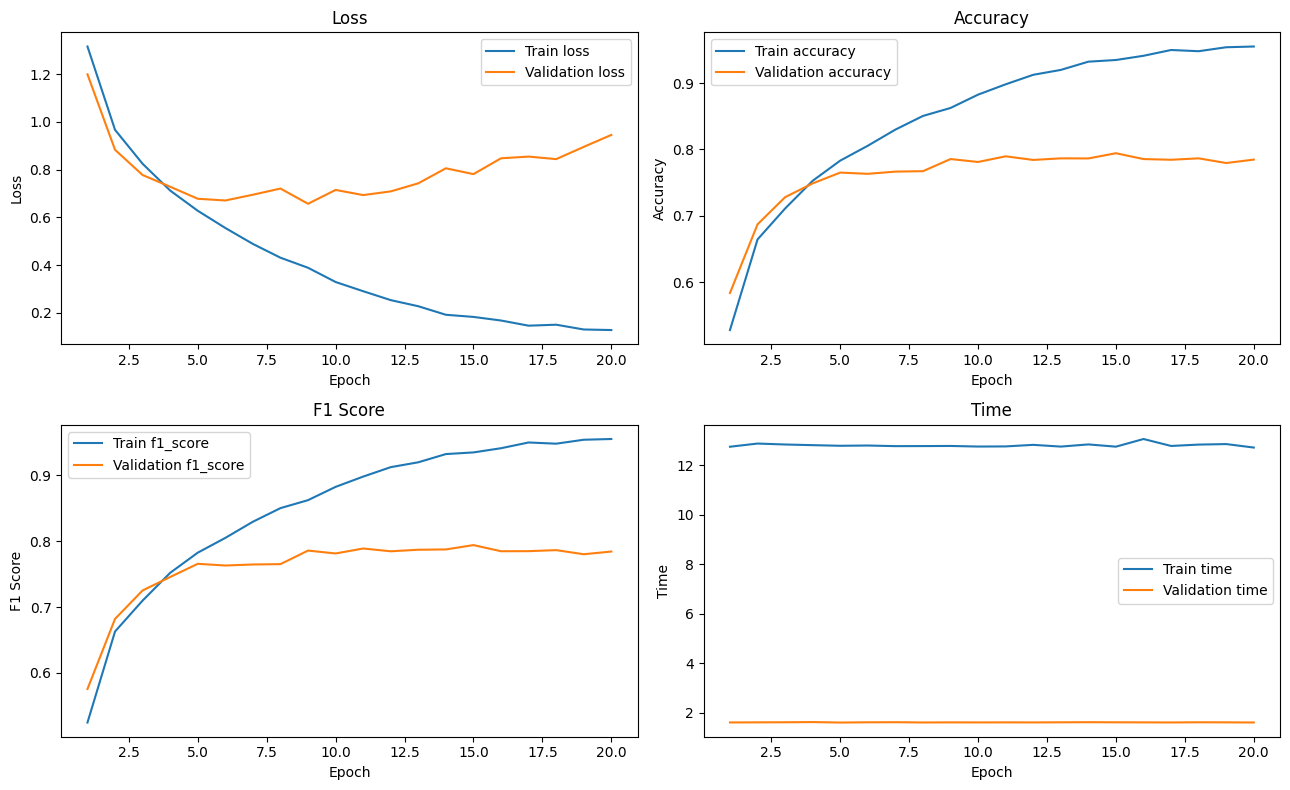

Loss: 0.92, Time: 2.21s, Accuracy: 0.79, F1 Score: 0.79
Training model with activationGELU


Epoch [1/20], Avg Loss: 1.3575, Time: 12.75s
Train loss: 1.36, accuracy: 0.51, f1_score: 0.51
Validation loss: 1.08, accuracy: 0.62, f1_score: 0.62


Epoch [2/20], Avg Loss: 1.0079, Time: 12.54s
Train loss: 1.01, accuracy: 0.65, f1_score: 0.65
Validation loss: 0.88, accuracy: 0.68, f1_score: 0.68


Epoch [3/20], Avg Loss: 0.8757, Time: 12.38s
Train loss: 0.88, accuracy: 0.69, f1_score: 0.69
Validation loss: 0.80, accuracy: 0.72, f1_score: 0.72


Epoch [4/20], Avg Loss: 0.7728, Time: 12.40s
Train loss: 0.77, accuracy: 0.73, f1_score: 0.73
Validation loss: 0.74, accuracy: 0.74, f1_score: 0.74


Epoch [5/20], Avg Loss: 0.6985, Time: 12.52s
Train loss: 0.70, accuracy: 0.76, f1_score: 0.76
Validation loss: 0.69, accuracy: 0.76, f1_score: 0.76


Epoch [6/20], Avg Loss: 0.6191, Time: 12.71s
Train loss: 0.62, accuracy: 0.78, f1_score: 0.78
Validation loss: 0.77, accuracy: 0.73, f1_score: 0.74


Epoch [7/20], Avg Loss: 0.5586, Time: 12.89s
Train loss: 0.56, accuracy: 0.81, f1_score: 0.81
Validation loss: 0.65, accuracy: 0.77, f1_score: 0.77


Epoch [8/20], Avg Loss: 0.5042, Time: 12.93s
Train loss: 0.50, accuracy: 0.83, f1_score: 0.82
Validation loss: 0.83, accuracy: 0.73, f1_score: 0.74


Epoch [9/20], Avg Loss: 0.4582, Time: 12.73s
Train loss: 0.46, accuracy: 0.84, f1_score: 0.84
Validation loss: 0.63, accuracy: 0.79, f1_score: 0.79


Epoch [10/20], Avg Loss: 0.3957, Time: 12.73s
Train loss: 0.40, accuracy: 0.86, f1_score: 0.86
Validation loss: 0.66, accuracy: 0.78, f1_score: 0.78


Epoch [11/20], Avg Loss: 0.3510, Time: 12.69s
Train loss: 0.35, accuracy: 0.88, f1_score: 0.88
Validation loss: 0.65, accuracy: 0.79, f1_score: 0.79


Epoch [12/20], Avg Loss: 0.3169, Time: 12.71s
Train loss: 0.32, accuracy: 0.89, f1_score: 0.89
Validation loss: 0.72, accuracy: 0.78, f1_score: 0.78


Epoch [13/20], Avg Loss: 0.2801, Time: 12.66s
Train loss: 0.28, accuracy: 0.90, f1_score: 0.90
Validation loss: 0.70, accuracy: 0.79, f1_score: 0.79


Epoch [14/20], Avg Loss: 0.2579, Time: 12.68s
Train loss: 0.26, accuracy: 0.91, f1_score: 0.91
Validation loss: 0.74, accuracy: 0.79, f1_score: 0.79


Epoch [15/20], Avg Loss: 0.2211, Time: 12.73s
Train loss: 0.22, accuracy: 0.92, f1_score: 0.92
Validation loss: 0.73, accuracy: 0.79, f1_score: 0.79


Epoch [16/20], Avg Loss: 0.1960, Time: 12.70s
Train loss: 0.20, accuracy: 0.93, f1_score: 0.93
Validation loss: 0.79, accuracy: 0.79, f1_score: 0.79


Epoch [17/20], Avg Loss: 0.1892, Time: 12.72s
Train loss: 0.19, accuracy: 0.93, f1_score: 0.93
Validation loss: 0.78, accuracy: 0.79, f1_score: 0.79


Epoch [18/20], Avg Loss: 0.1672, Time: 12.91s
Train loss: 0.17, accuracy: 0.94, f1_score: 0.94
Validation loss: 0.82, accuracy: 0.79, f1_score: 0.79


Epoch [19/20], Avg Loss: 0.1787, Time: 12.74s
Train loss: 0.18, accuracy: 0.94, f1_score: 0.94
Validation loss: 0.82, accuracy: 0.79, f1_score: 0.79


Epoch [20/20], Avg Loss: 0.1386, Time: 12.76s
Train loss: 0.14, accuracy: 0.95, f1_score: 0.95
Validation loss: 0.89, accuracy: 0.79, f1_score: 0.79


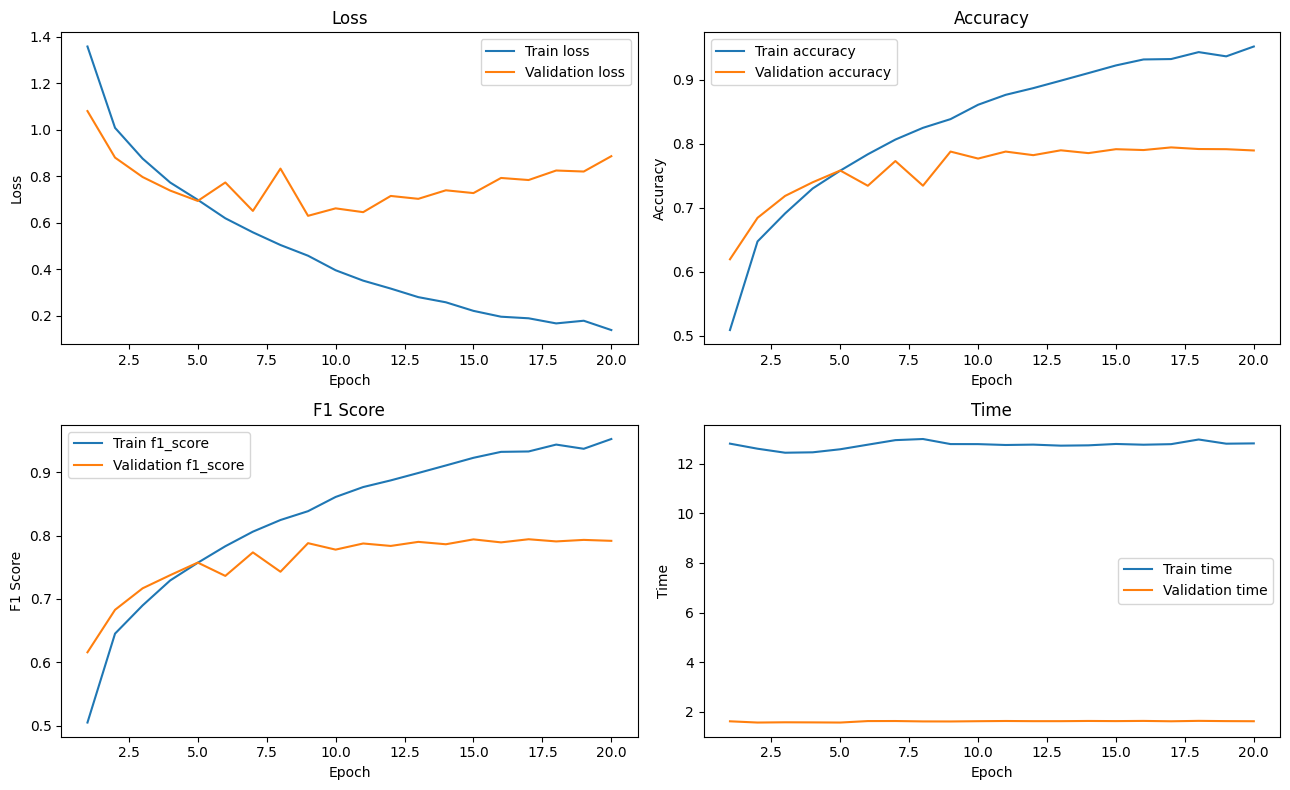

Loss: 0.87, Time: 2.17s, Accuracy: 0.79, F1 Score: 0.79
Training model with activationMish


Epoch [1/20], Avg Loss: 1.3695, Time: 12.64s
Train loss: 1.37, accuracy: 0.50, f1_score: 0.50
Validation loss: 1.09, accuracy: 0.62, f1_score: 0.62


Epoch [2/20], Avg Loss: 1.0076, Time: 12.76s
Train loss: 1.01, accuracy: 0.64, f1_score: 0.64
Validation loss: 0.91, accuracy: 0.68, f1_score: 0.67


Epoch [3/20], Avg Loss: 0.8538, Time: 12.67s
Train loss: 0.85, accuracy: 0.70, f1_score: 0.70
Validation loss: 0.77, accuracy: 0.73, f1_score: 0.73


Epoch [4/20], Avg Loss: 0.7489, Time: 12.44s
Train loss: 0.75, accuracy: 0.74, f1_score: 0.74
Validation loss: 0.71, accuracy: 0.75, f1_score: 0.75


Epoch [5/20], Avg Loss: 0.6588, Time: 12.41s
Train loss: 0.66, accuracy: 0.77, f1_score: 0.77
Validation loss: 0.70, accuracy: 0.75, f1_score: 0.75


Epoch [6/20], Avg Loss: 0.5843, Time: 12.54s
Train loss: 0.58, accuracy: 0.80, f1_score: 0.80
Validation loss: 0.69, accuracy: 0.76, f1_score: 0.75


Epoch [7/20], Avg Loss: 0.5223, Time: 12.87s
Train loss: 0.52, accuracy: 0.82, f1_score: 0.82
Validation loss: 0.65, accuracy: 0.77, f1_score: 0.78


Epoch [8/20], Avg Loss: 0.4559, Time: 12.81s
Train loss: 0.46, accuracy: 0.84, f1_score: 0.84
Validation loss: 0.64, accuracy: 0.79, f1_score: 0.79


Epoch [9/20], Avg Loss: 0.4018, Time: 13.20s
Train loss: 0.40, accuracy: 0.86, f1_score: 0.86
Validation loss: 0.63, accuracy: 0.79, f1_score: 0.79


Epoch [10/20], Avg Loss: 0.3499, Time: 13.38s
Train loss: 0.35, accuracy: 0.88, f1_score: 0.88
Validation loss: 0.67, accuracy: 0.79, f1_score: 0.79


Epoch [11/20], Avg Loss: 0.3144, Time: 13.28s
Train loss: 0.31, accuracy: 0.89, f1_score: 0.89
Validation loss: 0.66, accuracy: 0.79, f1_score: 0.79


Epoch [12/20], Avg Loss: 0.2713, Time: 12.95s
Train loss: 0.27, accuracy: 0.91, f1_score: 0.91
Validation loss: 0.70, accuracy: 0.79, f1_score: 0.79


Epoch [13/20], Avg Loss: 0.2372, Time: 12.89s
Train loss: 0.24, accuracy: 0.92, f1_score: 0.92
Validation loss: 0.74, accuracy: 0.79, f1_score: 0.79


Epoch [14/20], Avg Loss: 0.2190, Time: 12.93s
Train loss: 0.22, accuracy: 0.92, f1_score: 0.92
Validation loss: 0.74, accuracy: 0.80, f1_score: 0.79


Epoch [15/20], Avg Loss: 0.1968, Time: 12.93s
Train loss: 0.20, accuracy: 0.93, f1_score: 0.93
Validation loss: 0.82, accuracy: 0.77, f1_score: 0.77


Epoch [16/20], Avg Loss: 0.1823, Time: 12.85s
Train loss: 0.18, accuracy: 0.94, f1_score: 0.94
Validation loss: 0.77, accuracy: 0.79, f1_score: 0.79


Epoch [17/20], Avg Loss: 0.1879, Time: 12.98s
Train loss: 0.19, accuracy: 0.93, f1_score: 0.93
Validation loss: 0.78, accuracy: 0.80, f1_score: 0.80


Epoch [18/20], Avg Loss: 0.1458, Time: 12.98s
Train loss: 0.15, accuracy: 0.95, f1_score: 0.95
Validation loss: 0.83, accuracy: 0.79, f1_score: 0.79


Epoch [19/20], Avg Loss: 0.1458, Time: 12.97s
Train loss: 0.15, accuracy: 0.95, f1_score: 0.95
Validation loss: 0.89, accuracy: 0.78, f1_score: 0.78


Epoch [20/20], Avg Loss: 0.1570, Time: 13.09s
Train loss: 0.16, accuracy: 0.95, f1_score: 0.95
Validation loss: 0.86, accuracy: 0.80, f1_score: 0.80


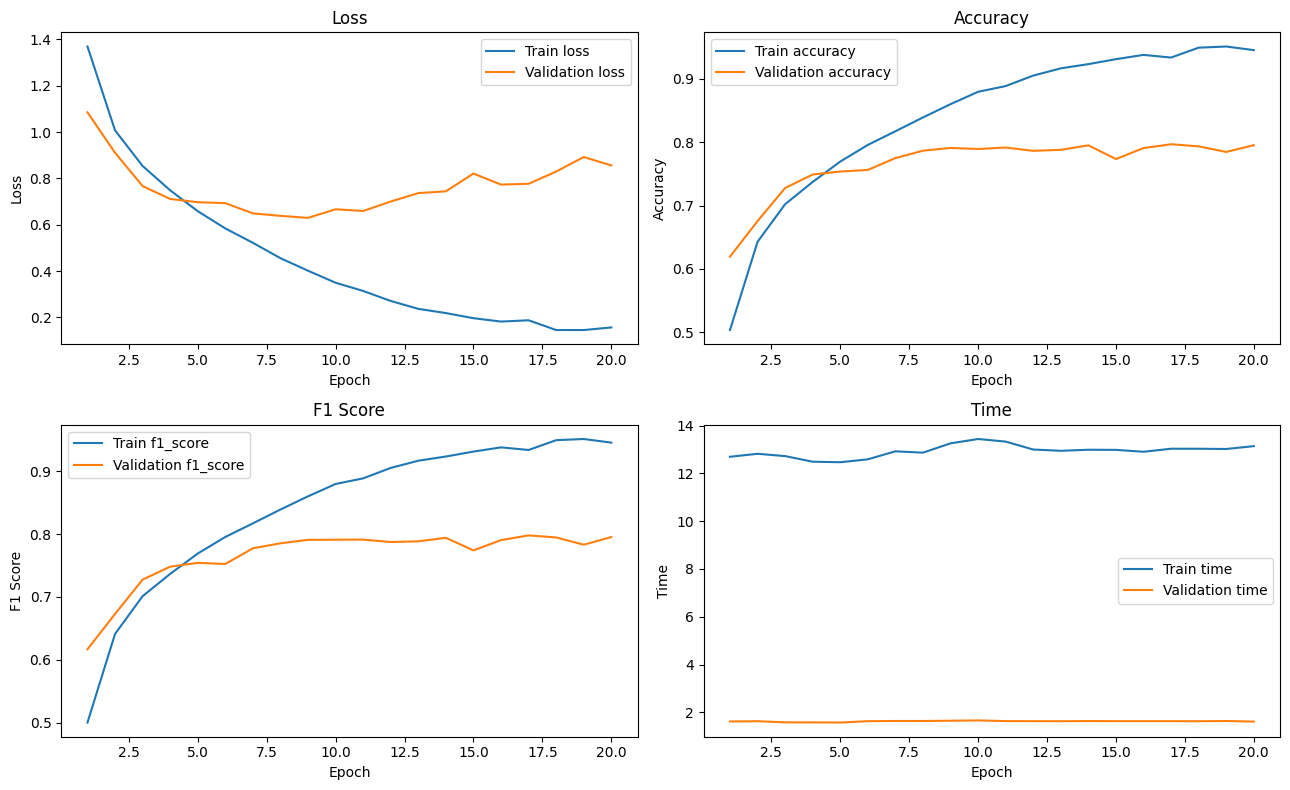

Loss: 0.91, Time: 2.18s, Accuracy: 0.79, F1 Score: 0.79
Training model with activationSELU


Epoch [1/20], Avg Loss: 1.4368, Time: 12.99s
Train loss: 1.44, accuracy: 0.49, f1_score: 0.49
Validation loss: 1.15, accuracy: 0.59, f1_score: 0.59


Epoch [2/20], Avg Loss: 1.0434, Time: 12.96s
Train loss: 1.04, accuracy: 0.63, f1_score: 0.63
Validation loss: 0.94, accuracy: 0.68, f1_score: 0.67


Epoch [3/20], Avg Loss: 0.9106, Time: 12.95s
Train loss: 0.91, accuracy: 0.68, f1_score: 0.68
Validation loss: 0.87, accuracy: 0.70, f1_score: 0.69


Epoch [4/20], Avg Loss: 0.8206, Time: 12.93s
Train loss: 0.82, accuracy: 0.71, f1_score: 0.71
Validation loss: 0.83, accuracy: 0.72, f1_score: 0.72


Epoch [5/20], Avg Loss: 0.7511, Time: 13.00s
Train loss: 0.75, accuracy: 0.74, f1_score: 0.74
Validation loss: 0.78, accuracy: 0.73, f1_score: 0.73


Epoch [6/20], Avg Loss: 0.6935, Time: 12.97s
Train loss: 0.69, accuracy: 0.76, f1_score: 0.76
Validation loss: 0.74, accuracy: 0.74, f1_score: 0.75


Epoch [7/20], Avg Loss: 0.6289, Time: 12.92s
Train loss: 0.63, accuracy: 0.78, f1_score: 0.78
Validation loss: 0.74, accuracy: 0.75, f1_score: 0.75


Epoch [8/20], Avg Loss: 0.5777, Time: 12.91s
Train loss: 0.58, accuracy: 0.80, f1_score: 0.80
Validation loss: 0.72, accuracy: 0.76, f1_score: 0.76


Epoch [9/20], Avg Loss: 0.5263, Time: 12.97s
Train loss: 0.53, accuracy: 0.82, f1_score: 0.82
Validation loss: 0.74, accuracy: 0.76, f1_score: 0.76


Epoch [10/20], Avg Loss: 0.4802, Time: 13.13s
Train loss: 0.48, accuracy: 0.83, f1_score: 0.83
Validation loss: 0.76, accuracy: 0.76, f1_score: 0.76


Epoch [11/20], Avg Loss: 0.4425, Time: 13.09s
Train loss: 0.44, accuracy: 0.84, f1_score: 0.84
Validation loss: 0.76, accuracy: 0.75, f1_score: 0.75


Epoch [12/20], Avg Loss: 0.3983, Time: 13.15s
Train loss: 0.40, accuracy: 0.86, f1_score: 0.86
Validation loss: 0.81, accuracy: 0.76, f1_score: 0.76


Epoch [13/20], Avg Loss: 0.3615, Time: 13.17s
Train loss: 0.36, accuracy: 0.87, f1_score: 0.87
Validation loss: 0.81, accuracy: 0.75, f1_score: 0.75


Epoch [14/20], Avg Loss: 0.3417, Time: 13.10s
Train loss: 0.34, accuracy: 0.88, f1_score: 0.88
Validation loss: 0.89, accuracy: 0.76, f1_score: 0.76


Epoch [15/20], Avg Loss: 0.3102, Time: 13.02s
Train loss: 0.31, accuracy: 0.89, f1_score: 0.89
Validation loss: 0.87, accuracy: 0.76, f1_score: 0.76


Epoch [16/20], Avg Loss: 0.2901, Time: 13.07s
Train loss: 0.29, accuracy: 0.90, f1_score: 0.90
Validation loss: 0.91, accuracy: 0.75, f1_score: 0.75


Epoch [17/20], Avg Loss: 0.2737, Time: 13.05s
Train loss: 0.27, accuracy: 0.90, f1_score: 0.90
Validation loss: 0.93, accuracy: 0.76, f1_score: 0.76


Epoch [18/20], Avg Loss: 0.2575, Time: 13.03s
Train loss: 0.26, accuracy: 0.91, f1_score: 0.91
Validation loss: 0.95, accuracy: 0.76, f1_score: 0.77


Epoch [19/20], Avg Loss: 0.2321, Time: 13.06s
Train loss: 0.23, accuracy: 0.92, f1_score: 0.92
Validation loss: 1.01, accuracy: 0.76, f1_score: 0.76


Epoch [20/20], Avg Loss: 0.2091, Time: 13.05s
Train loss: 0.21, accuracy: 0.93, f1_score: 0.93
Validation loss: 1.03, accuracy: 0.76, f1_score: 0.76


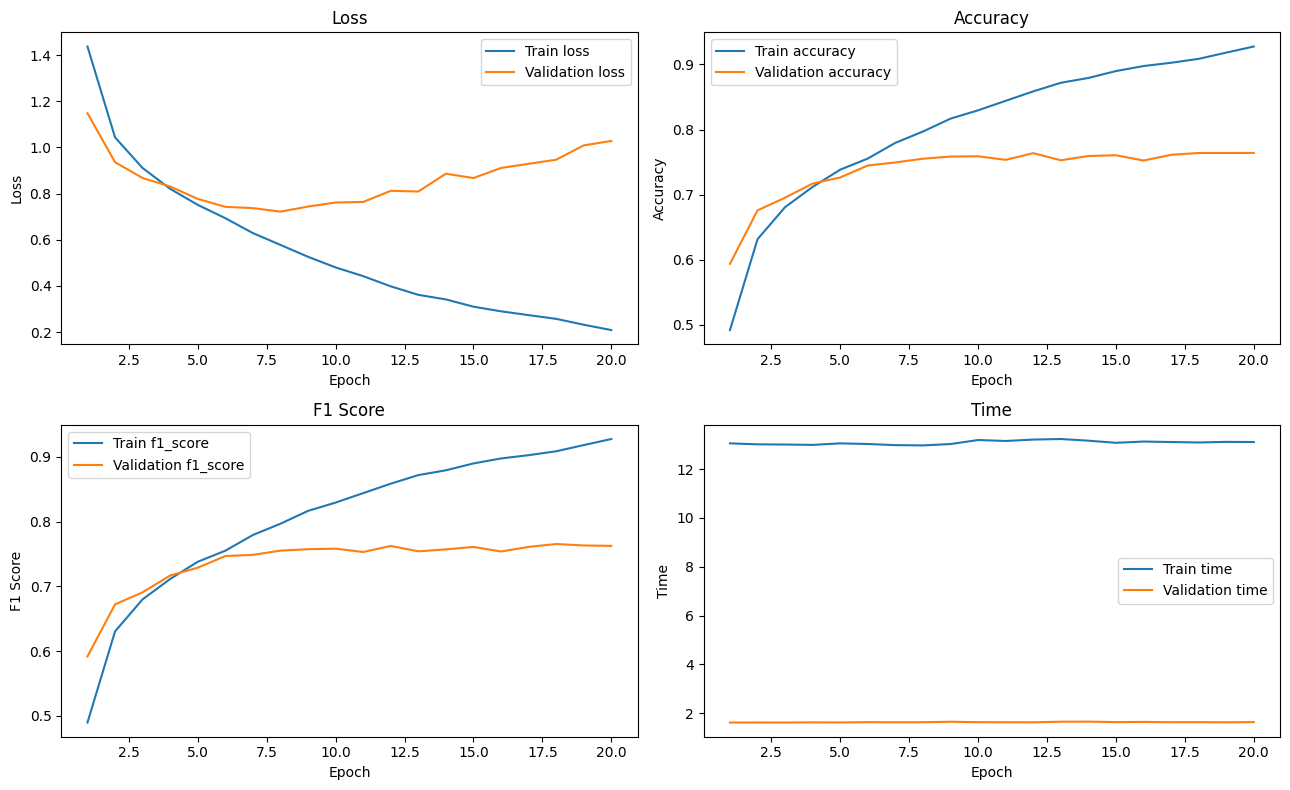

Loss: 1.06, Time: 2.23s, Accuracy: 0.77, F1 Score: 0.77


In [10]:
for name, activations in combinations_of_activations.items():
    model = CNNModel(activations).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    print(f"Training model with activation{name}")
    train_val_model(model, num_epochs=20)
    evaluate_model(model, test_loader)

<table style="border:2px solid black; border-collapse: collapse;"> <tr> <th style="border:2px solid black; padding:8px;"><b>Activation functions</b></th> <th style="border:2px solid black; padding:8px;"><b>Loss</b></th> <th style="border:2px solid black; padding:8px;"><b>Time</b></th> <th style="border:2px solid black; padding:8px;"><b>Accuracy</b></th> <th style="border:2px solid black; padding:8px;"><b>F1 Score</b></th> </tr> <tr> <td style="border:2px solid black; padding:8px;">ReLU</td> <td style="border:2px solid black; padding:8px;">0.83</td> <td style="border:2px solid black; padding:8px;">2.20s</td> <td style="border:2px solid black; padding:8px;">0.79</td> <td style="border:2px solid black; padding:8px;">0.79</td> </tr> <tr> <td style="border:2px solid black; padding:8px;">Sigmoid</td> <td style="border:2px solid black; padding:8px;">1.49</td> <td style="border:2px solid black; padding:8px;">2.18s</td> <td style="border:2px solid black; padding:8px;">0.56</td> <td style="border:2px solid black; padding:8px;">0.52</td> </tr> <tr> <td style="border:2px solid black; padding:8px;">Tanh</td> <td style="border:2px solid black; padding:8px;">1.01</td> <td style="border:2px solid black; padding:8px;">2.18s</td> <td style="border:2px solid black; padding:8px;">0.73</td> <td style="border:2px solid black; padding:8px;">0.73</td> </tr> <tr> <td style="border:2px solid black; padding:8px;">Leaky ReLU α = 0.01</td> <td style="border:2px solid black; padding:8px;">0.84</td> <td style="border:2px solid black; padding:8px;">2.17s</td> <td style="border:2px solid black; padding:8px;">0.79</td> <td style="border:2px solid black; padding:8px;">0.79</td> </tr> <tr> <td style="border:2px solid black; padding:8px;">Leaky ReLU α = 0.1</td> <td style="border:2px solid black; padding:8px;">0.99</td> <td style="border:2px solid black; padding:8px;">2.18s</td> <td style="border:2px solid black; padding:8px;">0.78</td> <td style="border:2px solid black; padding:8px;">0.78</td> </tr> <tr> <td style="border:2px solid black; padding:8px;">Leaky ReLU α = 0.2</td> <td style="border:2px solid black; padding:8px;">1.06</td> <td style="border:2px solid black; padding:8px;">2.18s</td> <td style="border:2px solid black; padding:8px;">0.77</td> <td style="border:2px solid black; padding:8px;">0.77</td> </tr> <tr> <td style="border:2px solid black; padding:8px;">Swish</td> <td style="border:2px solid black; padding:8px;">0.92</td> <td style="border:2px solid black; padding:8px;">2.21s</td> <td style="border:2px solid black; padding:8px;">0.79</td> <td style="border:2px solid black; padding:8px;">0.79</td> </tr> <tr> <td style="border:2px solid black; padding:8px;">GELU</td> <td style="border:2px solid black; padding:8px;">0.87</td> <td style="border:2px solid black; padding:8px;">2.17s</td> <td style="border:2px solid black; padding:8px;">0.79</td> <td style="border:2px solid black; padding:8px;">0.79</td> </tr> <tr> <td style="border:2px solid black; padding:8px;">Mish</td> <td style="border:2px solid black; padding:8px;">0.91</td> <td style="border:2px solid black; padding:8px;">2.18s</td> <td style="border:2px solid black; padding:8px;">0.79</td> <td style="border:2px solid black; padding:8px;">0.79</td> </tr> <tr> <td style="border:2px solid black; padding:8px;">SELU</td> <td style="border:2px solid black; padding:8px;">1.06</td> <td style="border:2px solid black; padding:8px;">2.23s</td> <td style="border:2px solid black; padding:8px;">0.77</td> <td style="border:2px solid black; padding:8px;">0.77</td> </tr> </table>